In [1]:
# Importing libraries

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import itertools as it
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

plt.rc('font', size=16)

import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers

# Setting random seed for reproducibility

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510])>

In [2]:
# Opening the dataframe
ABB_data = pd.read_csv('Multivariate_Labeled_2.csv', parse_dates=['DateTime'], delimiter=',')
ABB_data.drop(columns="DateTime", inplace=True)
ABB_data

,CB_First_Floor,CB_Second_Floor,AvgT,AvgH,Anomaly_Label,Year,Month,Day,Hour,Min,Sec,Day_Of_The_Week
0,37.0,36.0,4.70,80.40,0.0,2017.0,2.0,9.0,0.0,0.0,0.0,3.0
1,32.0,33.0,4.75,79.35,0.0,2017.0,2.0,9.0,0.0,15.0,0.0,3.0
2,32.0,32.0,4.60,78.90,0.0,2017.0,2.0,9.0,0.0,30.0,0.0,3.0
3,32.0,33.0,4.50,79.25,0.0,2017.0,2.0,9.0,0.0,45.0,0.0,3.0
4,33.0,33.0,4.40,80.40,0.0,2017.0,2.0,9.0,1.0,0.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
75835,41.0,41.0,10.95,83.25,0.0,2019.0,4.0,9.0,22.0,45.0,0.0,1.0
75836,42.0,42.0,10.80,84.60,0.0,2019.0,4.0,9.0,23.0,0.0,0.0,1.0
75837,43.0,43.0,10.65,86.05,0.0,2019.0,4.0,9.0,23.0,15.0,0.0,1.0
75838,42.0,42.0,10.30,86.90,0.0,2019.0,4.0,9.0,23.0,30.0,0.0,1.0


In [3]:
# Dataframe preprocessing

# Converting data types
ABB_data['CB_First_Floor'] = ABB_data['CB_First_Floor'].astype(np.float32)
ABB_data['CB_Second_Floor'] = ABB_data['CB_Second_Floor'].astype(np.float32)
ABB_data['AvgT'] = ABB_data['AvgT'].astype(np.float32)
ABB_data['AvgH'] = ABB_data['AvgH'].astype(np.float32)
ABB_data['Anomaly_Label'] = ABB_data['Anomaly_Label'].astype(np.float32)
ABB_data['Year'] = ABB_data['Year'].astype(np.float32)
ABB_data['Month'] = ABB_data['Month'].astype(np.float32)
ABB_data['Day'] = ABB_data['Day'].astype(np.float32)
ABB_data['Hour'] = ABB_data['Hour'].astype(np.float32)
ABB_data['Min'] = ABB_data['Min'].astype(np.float32)
ABB_data['Sec'] = ABB_data['Sec'].astype(np.float32)
ABB_data['Day_Of_The_Week'] = ABB_data['Day_Of_The_Week'].astype(np.float32)

# Printing the dataframe's info
ABB_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75840 entries, 0 to 75839
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CB_First_Floor   75840 non-null  float32
 1   CB_Second_Floor  75840 non-null  float32
 2   AvgT             75840 non-null  float32
 3   AvgH             75840 non-null  float32
 4   Anomaly_Label    75840 non-null  float32
 5   Year             75840 non-null  float32
 6   Month            75840 non-null  float32
 7   Day              75840 non-null  float32
 8   Hour             75840 non-null  float32
 9   Min              75840 non-null  float32
 10  Sec              75840 non-null  float32
 11  Day_Of_The_Week  75840 non-null  float32
dtypes: float32(12)
memory usage: 3.5 MB


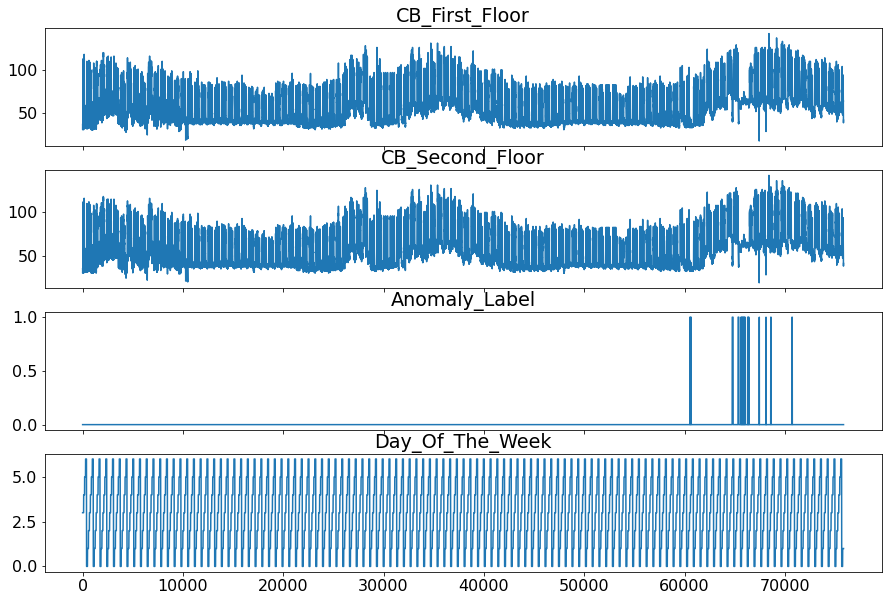

In [4]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(15,10))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()
    
# Plotting time series
inspect_dataframe(ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week"]], ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week"]].columns)

In [5]:
# Columns used for the following split in train, test and validation sets
ABB_data['Test'] = 0
ABB_data['Validation'] = 0
ABB_data['Train_P1'] = 0
ABB_data['Train_P2'] = 0

In [6]:
# TEST SET

# Some random weeks
week = [89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111]
for j in week:
    Slice_Multivariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,((j+1)*672)):
        ABB_data.at[k, 'Test'] = 1
        
j=112
for k in range((j)*672,((j+1)*672)-96):
        ABB_data.at[k, 'Test'] = 1

In [7]:
# VALIDATION SET

# Some random weeks
week = [55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78]
for j in week:
    Slice_Multivariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,(j+1)*672):
        ABB_data.at[k, 'Validation'] = 1

In [8]:
# TRAINING SET

week = [x for x in np.arange(0, 55, 1)]
for j in week:
    Slice_Univariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,(j+1)*672):
        ABB_data.at[k, 'Train_P1'] = 1
    
week = [x for x in np.arange(79, 89, 1)]
for j in week:
    Slice_Univariate_data = ABB_data.iloc[(j)*672:(j+1)*672]
    for k in range((j)*672,(j+1)*672):
        ABB_data.at[k, 'Train_P2'] = 1

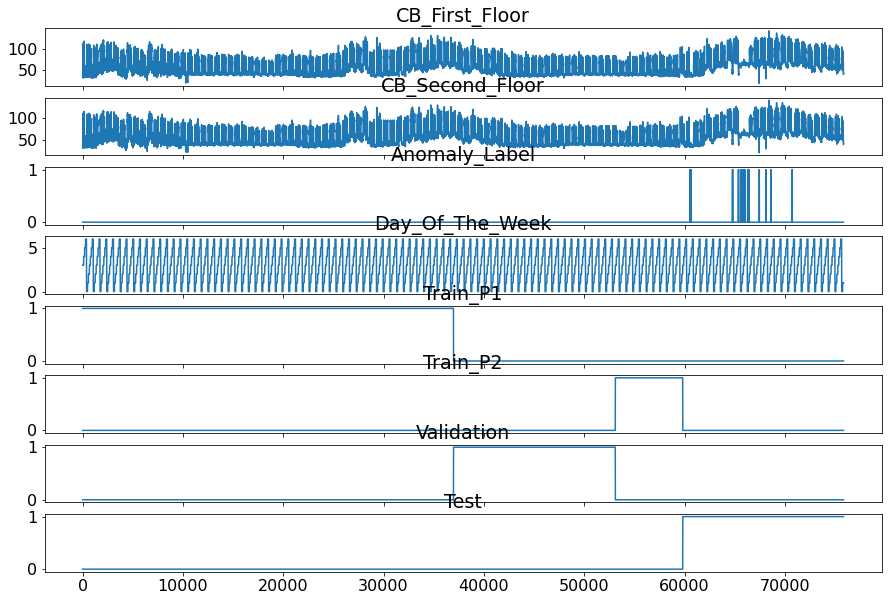

In [9]:
# Plotting time series
inspect_dataframe(ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week", "Train_P1", "Train_P2", "Validation", "Test"]], ABB_data[["CB_First_Floor", "CB_Second_Floor", "Anomaly_Label", "Day_Of_The_Week", "Train_P1", "Train_P2", "Validation", "Test"]].columns)

In [10]:
# TRAIN, TEST, VALIDATION SETS
X_train_temp_P1 = ABB_data[ABB_data['Train_P1']==1].copy()
X_train_temp_P2 = ABB_data[ABB_data['Train_P2']==1].copy()
X_validation_temp = ABB_data[ABB_data['Validation']==1].copy()
X_test_temp = ABB_data[ABB_data['Test']==1].copy()

In [11]:
# Training, Validation and Test set - Anomalies (not used for training)
Anomaly_Train_P1 = X_train_temp_P1[['Anomaly_Label']]
Anomaly_Train_P2 = X_train_temp_P2[['Anomaly_Label']]
Anomaly_Validation = X_validation_temp[['Anomaly_Label']]
Anomaly_Test = X_test_temp[['Anomaly_Label']]

In [12]:
Anomaly_Test.isna().sum()

Anomaly_Label    0
dtype: int64

In [13]:
X_train_temp_global = pd.concat([X_train_temp_P1,X_train_temp_P2],axis=0)
X_train_temp_global.shape

(43680, 16)

In [14]:
# STANDARDIZATION

mean = X_train_temp_global.mean()
std_dev = X_train_temp_global.std()
print(mean, std_dev)

X_train_raw_P1 = (X_train_temp_P1-mean)/std_dev
X_train_raw_P2 = (X_train_temp_P2-mean)/std_dev
X_validation_raw = (X_validation_temp-mean)/std_dev
X_test_raw = (X_test_temp-mean)/std_dev

print(X_test_raw.shape[0]+X_validation_raw.shape[0]+X_train_raw_P1.shape[0]+X_train_raw_P2.shape[0] == ABB_data.shape[0])

CB_First_Floor       56.138851
CB_Second_Floor      55.814743
AvgT                 14.077971
AvgH                 71.934769
Anomaly_Label         0.000000
Year               2016.190430
Month                 6.725275
Day                  15.931869
Hour                 11.500000
Min                  22.500000
Sec                   0.000000
Day_Of_The_Week       3.000000
Test                  0.000000
Validation            0.000000
Train_P1              0.846154
Train_P2              0.153846
dtype: float64 CB_First_Floor     19.434696
CB_Second_Floor    19.353397
AvgT                8.412559
AvgH               19.357700
Anomaly_Label       0.000000
Year                1.182342
Month               3.393301
Day                 8.643944
Hour                6.922266
Min                16.765793
Sec                 0.000000
Day_Of_The_Week     2.000023
Test                0.000000
Validation          0.000000
Train_P1            0.360805
Train_P2            0.360805
dtype: float64
True


In [15]:
# Anomalies are not considered during the training
X_train_raw_P1 = X_train_raw_P1[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_train_raw_P2 = X_train_raw_P2[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_validation_raw = X_validation_raw[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_test_raw = X_test_raw[['CB_First_Floor', 'CB_Second_Floor', 'Day_Of_The_Week']]
X_train_raw_P1.shape, X_train_raw_P2.shape, X_validation_raw.shape, X_test_raw.shape

((36960, 3), (6720, 3), (16128, 3), (16032, 3))

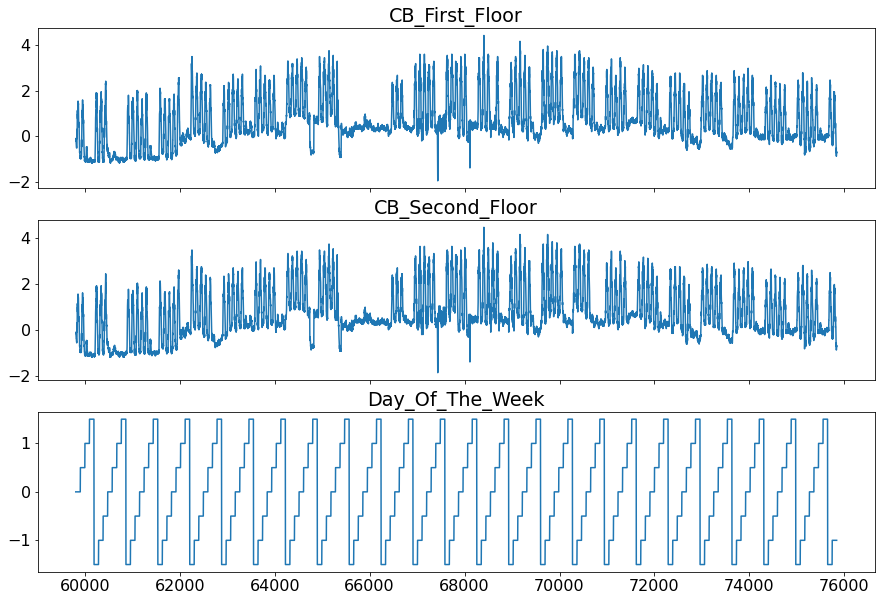

In [16]:
# Plotting time series
inspect_dataframe(X_test_raw, X_test_raw.columns)

## Training Preparation

In [17]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510])>

In [18]:
# Training parameters

window = 672       # 1 week
stride = 8         # 1 hour
latent_dim = 10    # Latent dimension
epochs = 300       # Number of epochs (no early stopping)
batch_size = 8     # Batch size
alpha = 0.5
M = 200

In [19]:
# Function used to create (overlapped) windows that we will use for the training
def build_sequences(df, anomaly, window=window, stride=stride):
    
    assert len(df) > window
    dataset = []
    anomalies = []
    temp_df = df.copy().values
    temp_an = anomaly.copy().values
    padding_len = (len(df)-window)%stride # Padding computed considering the stride
    print("PADDING: " + str(padding_len)) #DEBUG

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len,temp_df.shape[1]), dtype='float32')
        temp_df = np.concatenate((padding,df))
        padding = np.zeros((padding_len,temp_an.shape[1]), dtype='float32')
        temp_an = np.concatenate((padding,temp_an))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])
        anomalies.append(temp_an[idx:idx+window])

    dataset = np.array(dataset)
    anomalies = np.array(anomalies)
    return dataset, anomalies

In [20]:
X_train_P1, A_train_P1 = build_sequences(X_train_raw_P1, Anomaly_Train_P1, window=window, stride=stride)
X_train_P2, A_train_P2 = build_sequences(X_train_raw_P2, Anomaly_Train_P2, window=window, stride=stride)
X_val, A_val = build_sequences(X_validation_raw, Anomaly_Validation, window=window, stride=stride)
X_train_P1.shape,X_train_P2.shape

PADDING: 0
PADDING: 0
PADDING: 0


((4537, 672, 3), (757, 672, 3))

In [21]:
# Temp test set - plotting purposes
X_test, A_test = build_sequences(X_test_raw, Anomaly_Test, window=window, stride=stride)

PADDING: 0


In [22]:
X_train = np.concatenate([X_train_P1,X_train_P2],axis=0)
A_train = np.concatenate([A_train_P1,A_train_P2],axis=0)
X_train.shape, A_train.shape

((5294, 672, 3), (5294, 672, 1))

In [23]:
# Reparametrization trick
def sample(args):
    z_mean, z_log_var = args
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), seed=seed)
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [24]:
# Building the model

from keras import backend as K
from tensorflow.keras import Input

input_shape = X_train.shape[1:]
output_shape = X_train.shape[1:]

###########
# ENCODER #
###########

encoder_input = tf.keras.Input(shape=input_shape)

x = tfkl.LSTM(64, return_sequences=False)(encoder_input)

x = tfkl.Dense(latent_dim, activation='linear')(x)

# Latent representation: mean + log of std.dev.
z_mu = tfkl.Dense(latent_dim, name='latent_mu')(x) # Mean
z_sigma = tfkl.Dense(latent_dim, name='latent_sigma')(x) # Std.Dev. 

# Sampling a vector from the latent distribution
z = tfkl.Lambda(sample, output_shape=(latent_dim, ), name='z')([z_mu, z_sigma])

encoder = tfk.Model(encoder_input, [z_mu, z_sigma, z], name='encoder')
print(encoder.summary())

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 672, 3)]     0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 64)           17408       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 10)           650         ['lstm[0][0]']                   
                                                                                                  
 latent_mu (Dense)              (None, 10)           110         ['dense[0][0]']                  
                                                                                            

In [25]:
###########
# DECODER #
###########

decoder_input = Input(shape=(latent_dim, ), name='decoder_input')
convlstm = tfkl.RepeatVector(window)(decoder_input)
convlstm = tfkl.LSTM(64, return_sequences=True)(convlstm)
decoder_output = tfkl.TimeDistributed(tfkl.Dense(output_shape[1]))(convlstm)

# Define and summarize decoder model
decoder = tfk.Model(decoder_input, decoder_output, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 10)]              0         
                                                                 
 repeat_vector (RepeatVector  (None, 672, 10)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 672, 64)           19200     
                                                                 
 time_distributed (TimeDistr  (None, 672, 3)           195       
 ibuted)                                                         
                                                                 
Total params: 19,395
Trainable params: 19,395
Non-trainable params: 0
_________________________________________________________________


In [26]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510])>

In [27]:
# Sampling + Reparametrization trick
def sample_z1(z_m, z_l_v):
    z_mean = z_m 
    z_log_var = z_l_v
    eps = tf.keras.backend.random_normal(shape=(K.shape(z_mean)[0], K.int_shape(z_mean)[1]), seed=seed)
    return z_mean + tf.exp(alpha * z_log_var) * eps

In [28]:
class VAE(tfk.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tfk.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tfk.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = tfk.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def forward(self, x):
        outputs = {}
        
        z_mu, z_log_var, _ = self.encoder(x)
        z = sample_z1(z_mu,z_log_var)
        reconstruction = self.decoder(z)
        
        outputs["z_mu"] = z_mu
        outputs["z_log_var"] = z_log_var
        outputs["z"] = z
        outputs["reconstruction"] = reconstruction
        
        return outputs

    def train_step(self, y_true):
        with tf.GradientTape() as tape:
            
            z_mu, z_log_var, _ = self.encoder(y_true)
            z = sample_z1(z_mu,z_log_var)
            y_predict = self.decoder(z)
          
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(y_true, y_predict), axis=1))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result()
        }
    
    def test_step(self, data): #https://github.com/keras-team/keras-io/issues/38

        z_mu, z_log_var, _ = self.encoder(data)
        z = sample_z1(z_mu,z_log_var)
        y_predict = self.decoder(z)
          
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tfk.losses.mse(data, y_predict), axis=1))
            
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mu) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
        total_loss = reconstruction_loss + kl_loss
        
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss
        }

In [29]:
vae = VAE(encoder, decoder)

seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

vae.compile(optimizer=tfk.optimizers.Adam())
vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=100, 
        batch_size=batch_size)
vae.fit(x = X_train,
        validation_data = (X_val, None),
        epochs=epochs, 
        batch_size=batch_size,
        callbacks=[tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, min_lr=1e-5)]
       )

Epoch 1/100
662/662 [==============================] - 331s 493ms/step - loss: 654.1233 - reconstruction_loss: 644.0739 - kl_loss: 2.7532 - val_loss: 499.3359 - val_reconstruction_loss: 497.9496 - val_kl_loss: 1.3863
Epoch 2/100
662/662 [==============================] - 305s 460ms/step - loss: 640.5915 - reconstruction_loss: 633.4552 - kl_loss: 3.1322 - val_loss: 638.3528 - val_reconstruction_loss: 634.7323 - val_kl_loss: 3.6206
Epoch 3/100
662/662 [==============================] - 287s 434ms/step - loss: 652.7322 - reconstruction_loss: 630.2230 - kl_loss: 2.7696 - val_loss: 433.4052 - val_reconstruction_loss: 431.7699 - val_kl_loss: 1.6353
Epoch 4/100
662/662 [==============================] - 281s 425ms/step - loss: 631.1513 - reconstruction_loss: 634.1785 - kl_loss: 2.2606 - val_loss: 401.7593 - val_reconstruction_loss: 398.2894 - val_kl_loss: 3.4699
Epoch 5/100
662/662 [==============================] - 282s 426ms/step - loss: 634.2949 - reconstruction_loss: 633.1311 - kl_loss: 2

## Example of prediction on the test set

In [30]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [31]:
_, _, encoded_data = encoder(X_test) 
predictions = decoder(encoded_data)

for l in range(M):
    print(l)
    _, _, encoded_data = encoder(X_test) 
    reconstruction = decoder(encoded_data)
    predictions = predictions + reconstruction
    
predictions = predictions/M
print(predictions.shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
(1921, 672, 3)


In [32]:
def inspect_multivariate_prediction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))

    figs, axs = plt.subplots(len(columns) + 1, 1, sharex=True, figsize=(17,10))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
           
    axs[len(columns)].plot(np.arange(len(X[0,:,i])), a[idx,:])
    axs[len(columns)].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope, ), a[idx,:])
    axs[len(columns)].set_title('Anomaly')
    plt.show()

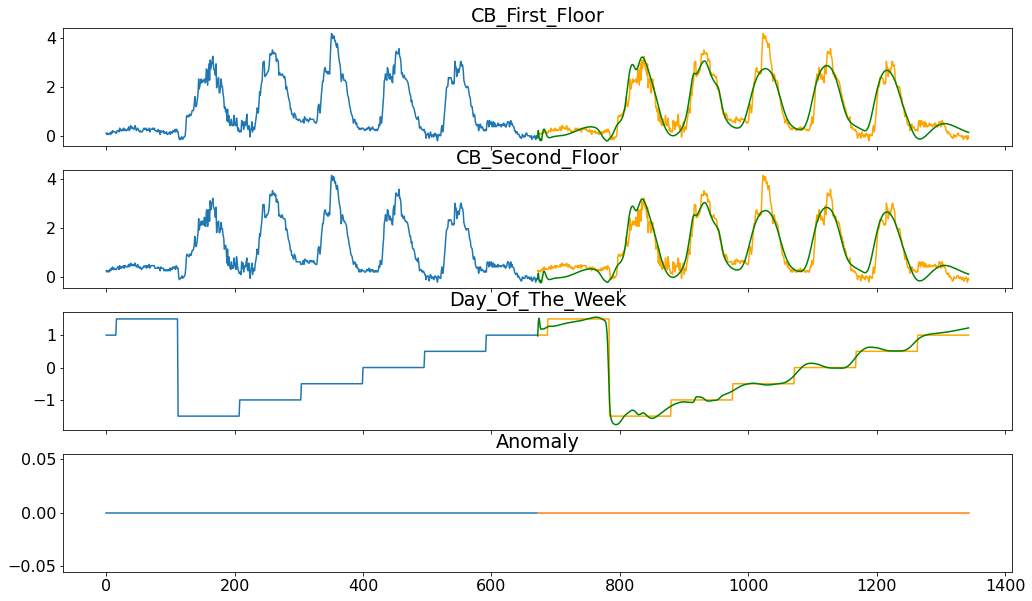

In [33]:
# Plotting predictions
target_labels = X_test_raw.columns
inspect_multivariate_prediction(X_test, X_test, A_test, predictions, target_labels, window)

## Computing reconstruction error

In [34]:
# Function used to create non-overlapped windows starting from the TRAINING set
def build_sequences_reconstruction(df, window, stride):
    dataset = []
    temp_df = df.copy().values
    padding_len = (len(df)-window)%stride

    for idx in np.arange(0,len(temp_df)-window+1,stride):
        dataset.append(temp_df[idx:idx+window])

    dataset = np.array(dataset)
    return dataset

In [35]:
# Non overlapped windows - Training set
X_train_non_overlapped_P1 = build_sequences_reconstruction(X_train_raw_P1, window=window, stride=window)
X_train_non_overlapped_P2 = build_sequences_reconstruction(X_train_raw_P2, window=window, stride=window)

X_train_non_overlapped = np.concatenate([X_train_non_overlapped_P1,X_train_non_overlapped_P2],axis=0)

X_train_non_overlapped.shape

(65, 672, 3)

In [36]:
# Overlapped windows - Test set
X_test_overlapped = build_sequences_reconstruction(X_test_raw, window=window, stride=stride)
X_test_overlapped.shape

(1921, 672, 3)

In [37]:
# Making predictions on non-overlapped windows of the training set
encoded_data = encoder(X_train_non_overlapped)[-1]
print(encoded_data.shape)
train_reconstructions = decoder(encoded_data)
print(train_reconstructions.shape)

for l in range(M-1):
    encoded_data = encoder(X_train_non_overlapped)[-1]
    train_prediction = decoder(encoded_data)
    train_reconstructions = train_prediction + train_reconstructions
    
train_reconstructions = train_reconstructions/M
print(train_reconstructions.shape)

(65, 10)
(65, 672, 3)
(65, 672, 3)


In [38]:
# Making predictions on overlapped windows of the test set
encoded_data = encoder(X_test_overlapped)[-1]
print(encoded_data.shape)
test_reconstructions = decoder(encoded_data)
print(test_reconstructions.shape)

for l in range(M-1):
    encoded_data = encoder(X_test_overlapped)[-1]
    test_prediction = decoder(encoded_data)
    test_reconstructions = test_prediction + test_reconstructions
    
test_reconstructions = test_reconstructions/M
print(test_reconstructions.shape)

(1921, 10)
(1921, 672, 3)
(1921, 672, 3)


In [39]:
# Computing reconstruction error - Test set (redundant data because of overlapping)
rec_error = np.abs(X_test_overlapped-test_reconstructions) # || True - Predicted ||
rec_error.shape

(1921, 672, 3)

In [40]:
# Function used to plot predictions (reconstructions) made on training data using the model
def inspect_multivariate_prediction_reconstruction(X, y, a, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(pred))
        print('Plotting sequence number: ' + str(idx))

    figs, axs = plt.subplots(3, 1, sharex=True, figsize=(17,7))
    for i, col in enumerate(columns[:4]):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].plot(np.arange(len(X[0,:,i]), len(X[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
    plt.show()

Plotting sequence number: 51


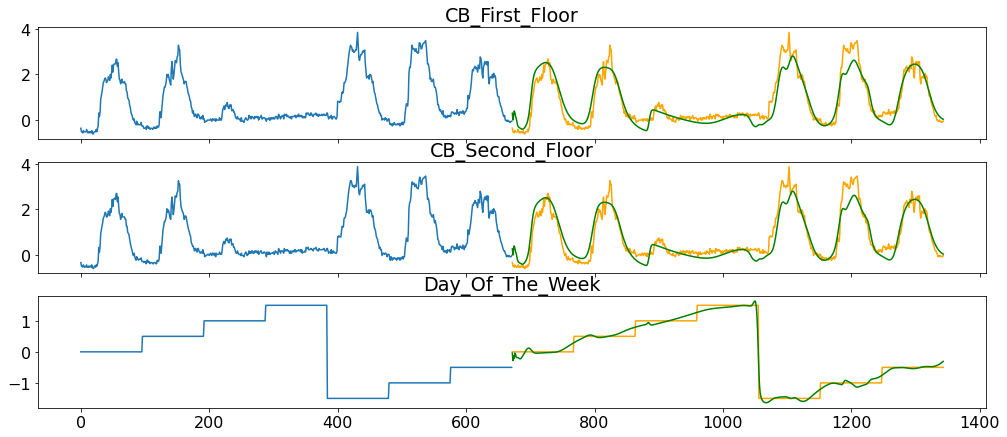

In [41]:
# Plotting reconstructions of the TRAINING set
inspect_multivariate_prediction_reconstruction(X_train_non_overlapped, X_train_non_overlapped, A_train, train_reconstructions, target_labels, window)

In [42]:
# Array that will contain reconstruction errors (floor by floor) - TRAINING SET
reconstruction_errors = np.empty(shape=(0, 2))

# Computing reconstruction errors
for i in range(X_train_non_overlapped.shape[0]):
    error = np.abs(X_train_non_overlapped[i]-train_reconstructions[i])
    error = error[:,:2] # Not interested in the day of the week
    reconstruction_errors = np.concatenate((reconstruction_errors,error), axis=0)
    
mean_error = np.mean(reconstruction_errors, axis = 0) # Mean reconstruction error
std_error = np.std(reconstruction_errors, axis = 0) # Std dev of the reconstruction error
max_error = np.max(reconstruction_errors, axis = 0) # Max error on the training set
  
print(reconstruction_errors.shape)
print(mean_error)
print(std_error)
print(max_error)

(43680, 2)
[0.23418076 0.23437381]
[0.21814951 0.21734936]
[1.93185496 1.91032577]


In [43]:
# Array that will contain reconstruction errors (floor by floor) - TEST SET

reconstruction_test = np.empty(shape=(0, 2)) # Predictions made on the test set using the model
reconstruction_errors_test = np.empty(shape=(0, 2)) # Errors made in predicting the test set

# First window
i = 0
error = np.abs(X_test_overlapped[i]-test_reconstructions[i])
error = error[:,:2] # Not interested in the day of the week
reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,:,:2]), axis=0)
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

# For all the windows following the first one we need to consider only the last "stride" elements
for i in range(1,X_test_overlapped.shape[0]):
    error = np.abs(X_test_overlapped[i,-stride:,:]-test_reconstructions[i,-stride:,:])
    error = error[:,:2] # Not interested in the day of the week
    reconstruction_errors_test = np.concatenate((reconstruction_errors_test,error), axis=0)
    reconstruction_test = np.concatenate((reconstruction_test, test_reconstructions[i,-stride:,:2]), axis=0)
                                        
print(reconstruction_errors_test.shape)
print(reconstruction_test.shape)

(672, 2)
(672, 2)
(16032, 2)
(16032, 2)


In [44]:
# Function used to predict anomalies
def predict_anomalies(reconstruction_errors, error_threshold):
    
    # Inizially we don't have predicted anomalies
    anomaly_predicted = np.zeros(shape=(X_test_raw.shape[0]))
    
    # First window
    i = 0 # We start from element 0 of the test set
    seq = reconstruction_errors[0] # We start from the first window of the test set 
    for sample in seq: 
        epsilon = sample[:2] - error_threshold # We check if the reconstruction error is greater than the threshold
        if any(x>0 for x in epsilon) == True:
            anomaly_predicted[i] = 1
        i = i+1
            
    # Sequences following the first one
    for s in range(1, reconstruction_errors.shape[0]):
        for k in range (reconstruction_errors.shape[1]-stride, reconstruction_errors.shape[1]): # k in [672-stride, 672]         
            epsilon = reconstruction_errors[s,k,:2] - error_threshold # We check if the reconstruction error is greater than the threshold
            if any(x>0 for x in epsilon) == True:
                anomaly_predicted[i] = 1
            i = i+1 

    return anomaly_predicted

In [45]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
tfp.random.sanitize_seed(seed)

<tf.Tensor: shape=(2,), dtype=int32, numpy=array([2083866985, -350068510])>

In [46]:
Anomaly_Test

,Anomaly_Label
59808,0.0
59809,0.0
59810,0.0
59811,0.0
59812,0.0
...,...
75835,0.0
75836,0.0
75837,0.0
75838,0.0


In [58]:
# Grid search threshold parameters

range_of_val = [x for x in np.arange(4, 7, 0.1)]
best_val = [0,0]
F1_MAX = 0

for i in range_of_val:
    for j in range_of_val:
        threshold_error_mean_std_TEMP = 0
        threshold_error_mean_std_TEMP = mean_error + [i,j]*std_error # mean + n*std_dev
        anomaly_predicted_mean_std_TEMP = 0
        anomaly_predicted_mean_std_TEMP = predict_anomalies(rec_error, threshold_error_mean_std_TEMP)
        f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted_mean_std_TEMP)
        if(f1>F1_MAX):
            F1_MAX = f1
            best_val = [i,j]
            print("best threshold parameters: " + str(best_val) + " best f1: " + str(F1_MAX))
            
threshold_error_mean_std = mean_error + [best_val[0],best_val[1]]*std_error # mean + n*std_dev
anomaly_predicted_mean_std = predict_anomalies(rec_error, threshold_error_mean_std)
                
threshold_error_max = max_error # Max error on the training set
anomaly_predicted_max = predict_anomalies(rec_error, threshold_error_max)

anomaly_predicted_mean_std.sum(), anomaly_predicted_max.sum(), anomaly_predicted_mean_std.shape, anomaly_predicted_max.shape, threshold_error_mean_std, threshold_error_max

best threshold parameters: [4.0, 4.0] best f1: 0.6801099908340972
best threshold parameters: [4.0, 4.1] best f1: 0.6833333333333333
best threshold parameters: [4.0, 4.299999999999999] best f1: 0.6840148698884759
best threshold parameters: [4.0, 4.399999999999999] best f1: 0.6852886405959031
best threshold parameters: [4.0, 4.499999999999998] best f1: 0.6859273066169619
best threshold parameters: [4.0, 4.599999999999998] best f1: 0.6865671641791045
best threshold parameters: [4.0, 4.899999999999997] best f1: 0.6878504672897197
best threshold parameters: [4.0, 5.099999999999996] best f1: 0.6891385767790262
best threshold parameters: [4.0, 5.399999999999995] best f1: 0.6904315196998123
best threshold parameters: [4.0, 5.799999999999994] best f1: 0.6910798122065728
best threshold parameters: [4.0, 6.299999999999992] best f1: 0.6917293233082706
best threshold parameters: [4.0, 6.599999999999991] best f1: 0.6923800564440263


(520.0,
 140.0,
 (16032,),
 (16032,),
 array([1.1067788 , 1.66887962]),
 array([1.93185496, 1.91032577]))

In [48]:
padding_len = (len(X_test_raw)-window)%stride
size = X_test_raw.shape[0]-padding_len
X_test_raw = X_test_raw[:size]
X_test_raw.shape[1]

3

In [49]:
# Adding predictions and predicted anomalies to X_test_raw
X_test_raw['Reconstr_1_Floor'] = reconstruction_test[:,0] # Prediction on floor 1
X_test_raw['Reconstr_2_Floor'] = reconstruction_test[:,1] # Prediction on floor 2
X_test_raw['Anomaly_Label_GT'] = Anomaly_Test # Ground truth anomalies
X_test_raw['Anomaly_Predicted_Mean_Std'] = anomaly_predicted_mean_std[:X_test_raw.shape[0]] # Anomalies predicted using mean and std dev
X_test_raw['Anomaly_Predicted_Max'] = anomaly_predicted_max[:X_test_raw.shape[0]] # Anomalies predicted using max error on the training set
X_test_raw['Error_1_Floor'] = reconstruction_errors_test[:,0] # Prediction error on floor 1
X_test_raw['Error_2_Floor'] = reconstruction_errors_test[:,1] # Prediction error on floor 2
X_test_raw.head()

,CB_First_Floor,CB_Second_Floor,Day_Of_The_Week,Reconstr_1_Floor,Reconstr_2_Floor,Anomaly_Label_GT,Anomaly_Predicted_Mean_Std,Anomaly_Predicted_Max,Error_1_Floor,Error_2_Floor
59808,-0.110053,-0.145439,0.0,-0.075500,-0.095430,0.0,0.0,0.0,0.034553,0.050009
59809,-0.110053,-0.145439,0.0,-0.616766,-0.634463,0.0,0.0,0.0,0.506712,0.489023
59810,-0.110053,-0.093769,0.0,-0.351647,-0.303539,0.0,0.0,0.0,0.241594,0.209770
59811,-0.161508,-0.145439,0.0,-0.199493,-0.176602,0.0,0.0,0.0,0.037986,0.031162
59812,-0.161508,-0.145439,0.0,-0.262504,-0.297365,0.0,0.0,0.0,0.100996,0.151926


In [50]:
# Function used to plot time series
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(30,20))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

In [52]:
def inspect_multivariate_prediction(X, y, a_true, a_predicted_mean_std, a_predicted_max, pred, columns, error_1F, error_2F): 
   
    figs, axs = plt.subplots(7, 1, sharex=True, figsize=(17,17)) 
    for i, col in enumerate(columns[:2]): 
        axs[i].plot(np.arange(len(X[:,i])), X[:,i]) 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), y[:,i], color='orange') 
        axs[i].plot(np.arange(len(X[:,i]), len(X[:,i])*2), pred[:,i], color='green') 
        axs[i].set_title(col) 
        
    axs[2].plot(np.arange(len(X[:,i])), error_1F) 
    axs[2].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_1F) 
    axs[2].set_title('error_1F') 
     
    axs[3].plot(np.arange(len(X[:,i])), error_2F) 
    axs[3].plot(np.arange(len(X[:,i]), len(X[:,i])*2), error_2F) 
    axs[3].set_title('error_2F') 
            
    axs[4].plot(np.arange(len(X[:,i])), a_true) 
    axs[4].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_true) 
    axs[4].set_title('Anomaly_True') 
    
    axs[5].plot(np.arange(len(X[:,i])), a_predicted_mean_std) 
    axs[5].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_mean_std) 
    axs[5].set_title('Anomaly_Predicted_Mean_Std_Dev')
    
    axs[6].plot(np.arange(len(X[:,i])), a_predicted_max) 
    axs[6].plot(np.arange(len(X[:,i]), len(X[:,i])*2), a_predicted_max) 
    axs[6].set_title('Anomaly_Predicted_Max') 
    plt.show()

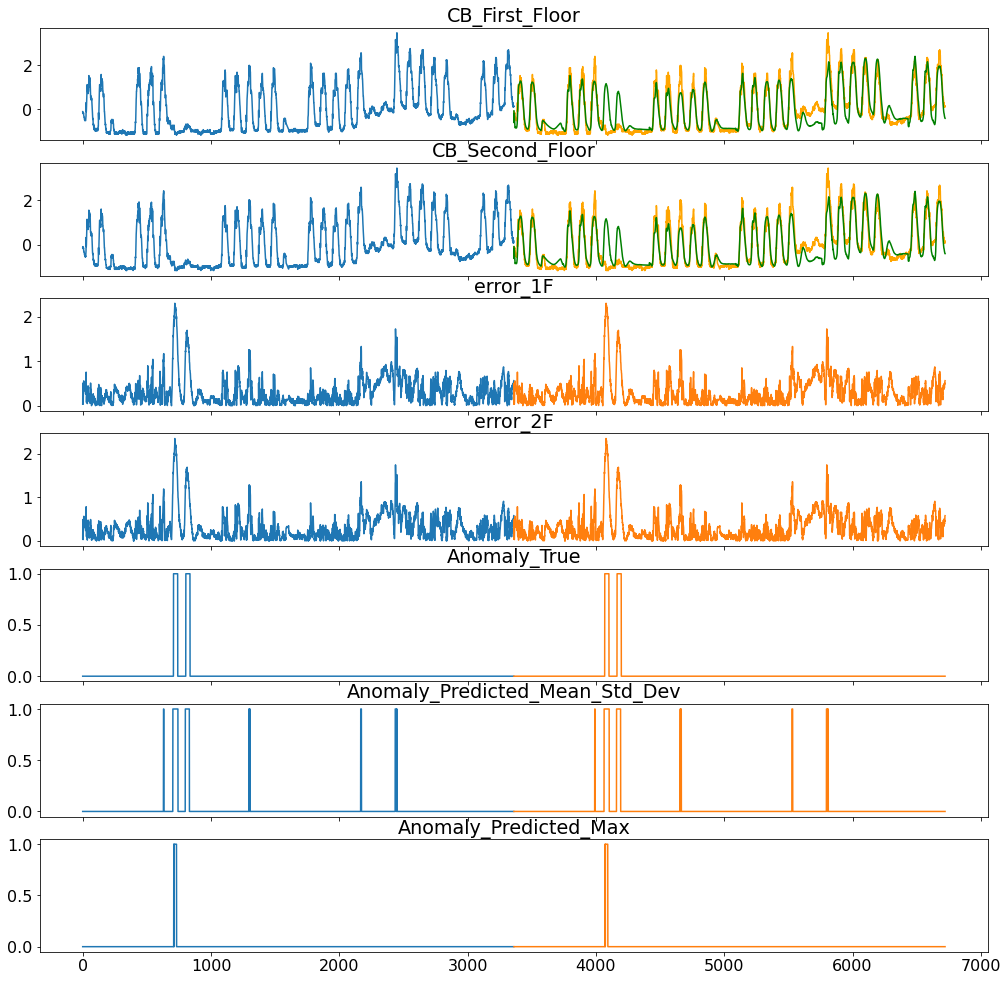

In [62]:
# Plotting reconstructions for a check
import datetime as dt

i=89 # da 89 in poi
j=i+5

X = np.array(X_test_raw.loc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
predictions = np.array(X_test_raw.loc[i*672:j*672][['Reconstr_1_Floor', 'Reconstr_2_Floor']])
anomaly_true = X_test_raw.loc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.loc[i*672:j*672]['Error_1_Floor']
error_2F = X_test_raw.loc[i*672:j*672]['Error_2_Floor']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F, error_2F) # X = ABB_print

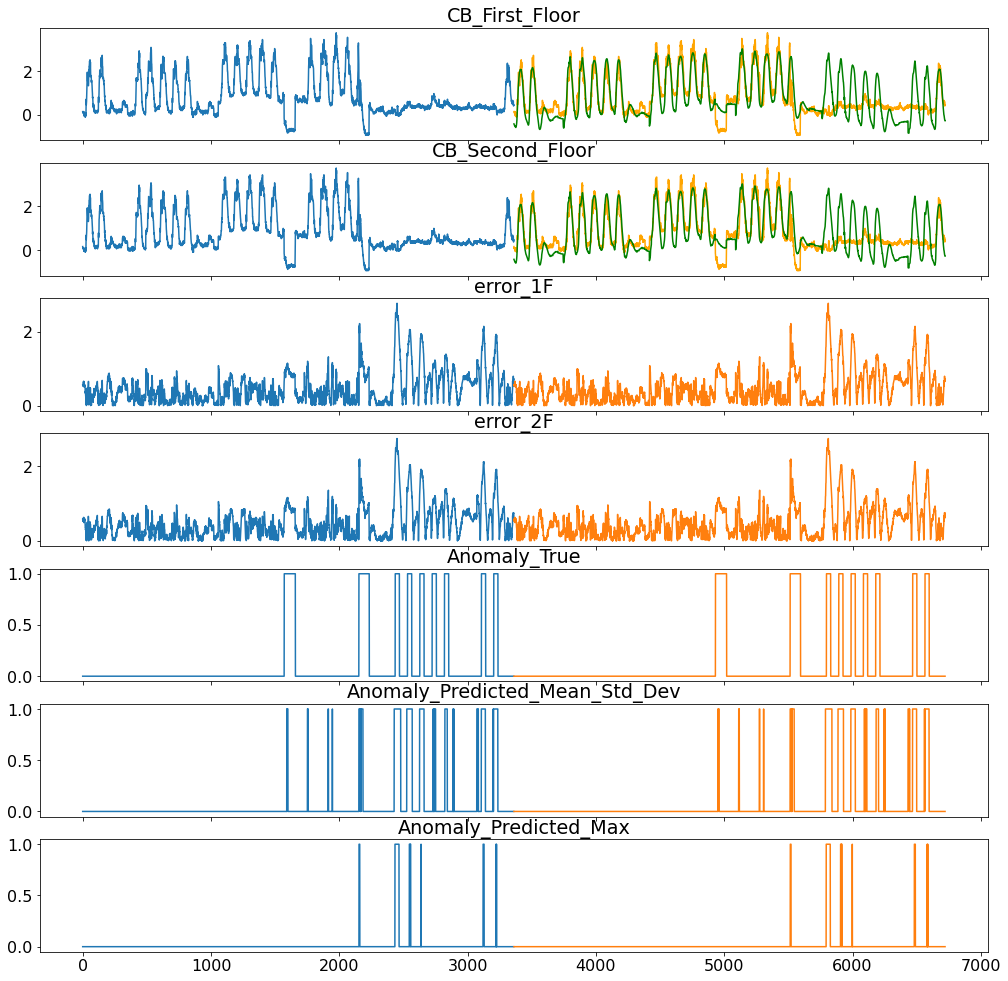

In [59]:
# Plotting reconstructions for a check
import datetime as dt

i=94 # da 89 in poi
j=i+5

X = np.array(X_test_raw.loc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
predictions = np.array(X_test_raw.loc[i*672:j*672][['Reconstr_1_Floor', 'Reconstr_2_Floor']])
anomaly_true = X_test_raw.loc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.loc[i*672:j*672]['Error_1_Floor']
error_2F = X_test_raw.loc[i*672:j*672]['Error_2_Floor']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F, error_2F) # X = ABB_print

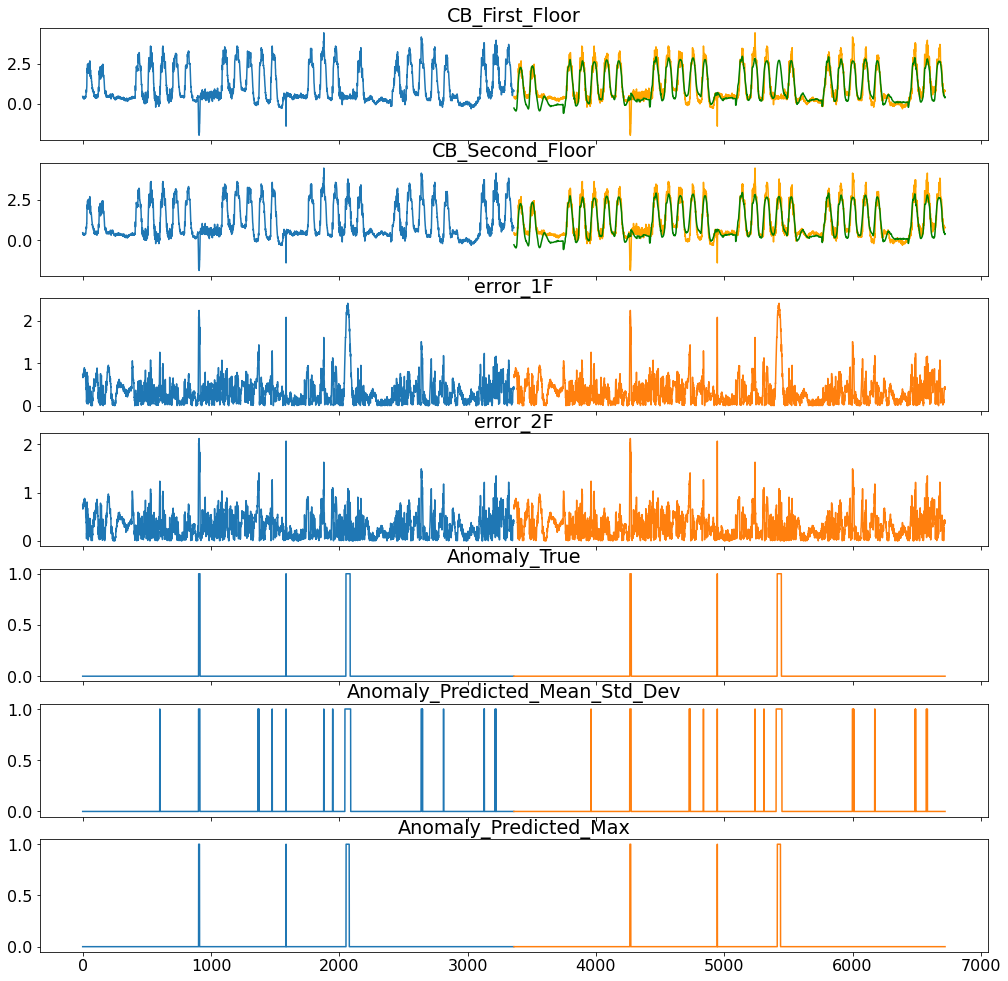

In [60]:
# Plotting reconstructions for a check
import datetime as dt

i=99 # da 89 in poi
j=i+5

X = np.array(X_test_raw.loc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
predictions = np.array(X_test_raw.loc[i*672:j*672][['Reconstr_1_Floor', 'Reconstr_2_Floor']])
anomaly_true = X_test_raw.loc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.loc[i*672:j*672]['Error_1_Floor']
error_2F = X_test_raw.loc[i*672:j*672]['Error_2_Floor']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F, error_2F) # X = ABB_print

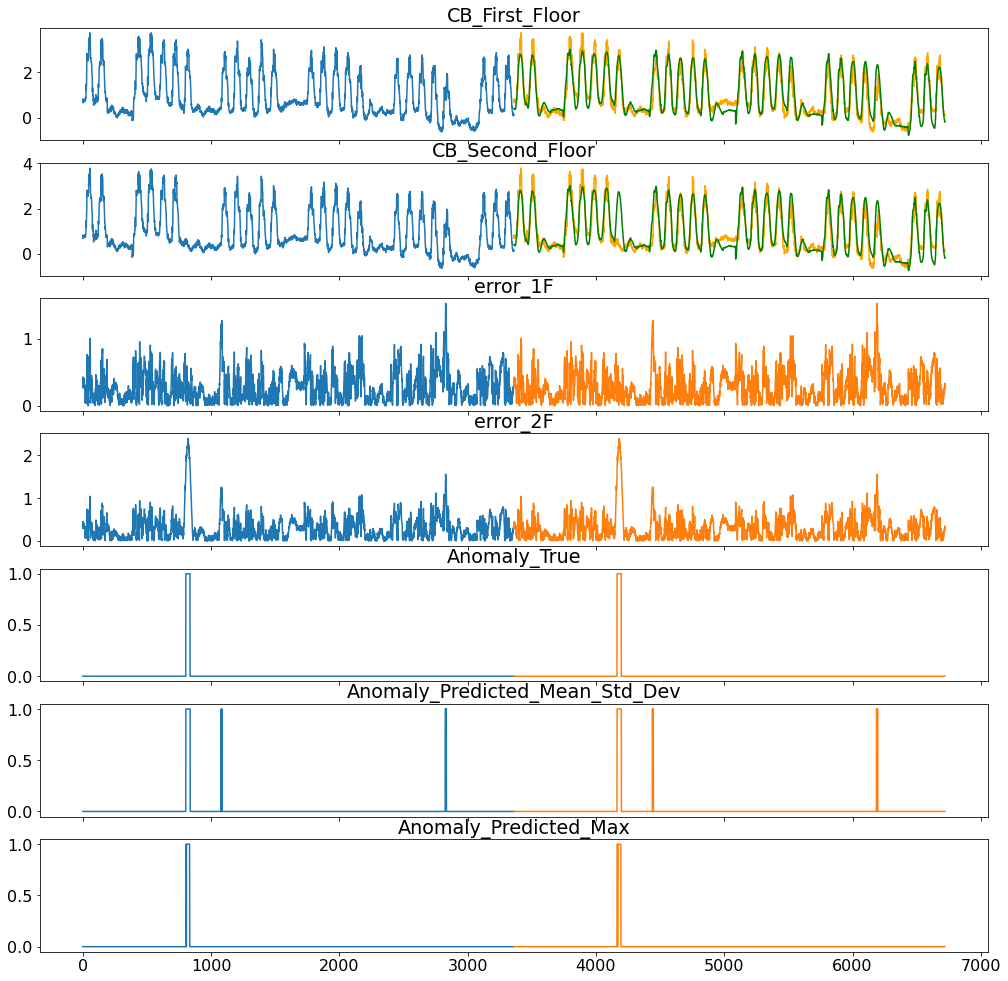

In [61]:
# Plotting reconstructions for a check
import datetime as dt

i=104 # da 89 in poi
j=i+5

X = np.array(X_test_raw.loc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
predictions = np.array(X_test_raw.loc[i*672:j*672][['Reconstr_1_Floor', 'Reconstr_2_Floor']])
anomaly_true = X_test_raw.loc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.loc[i*672:j*672]['Error_1_Floor']
error_2F = X_test_raw.loc[i*672:j*672]['Error_2_Floor']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F, error_2F) # X = ABB_print

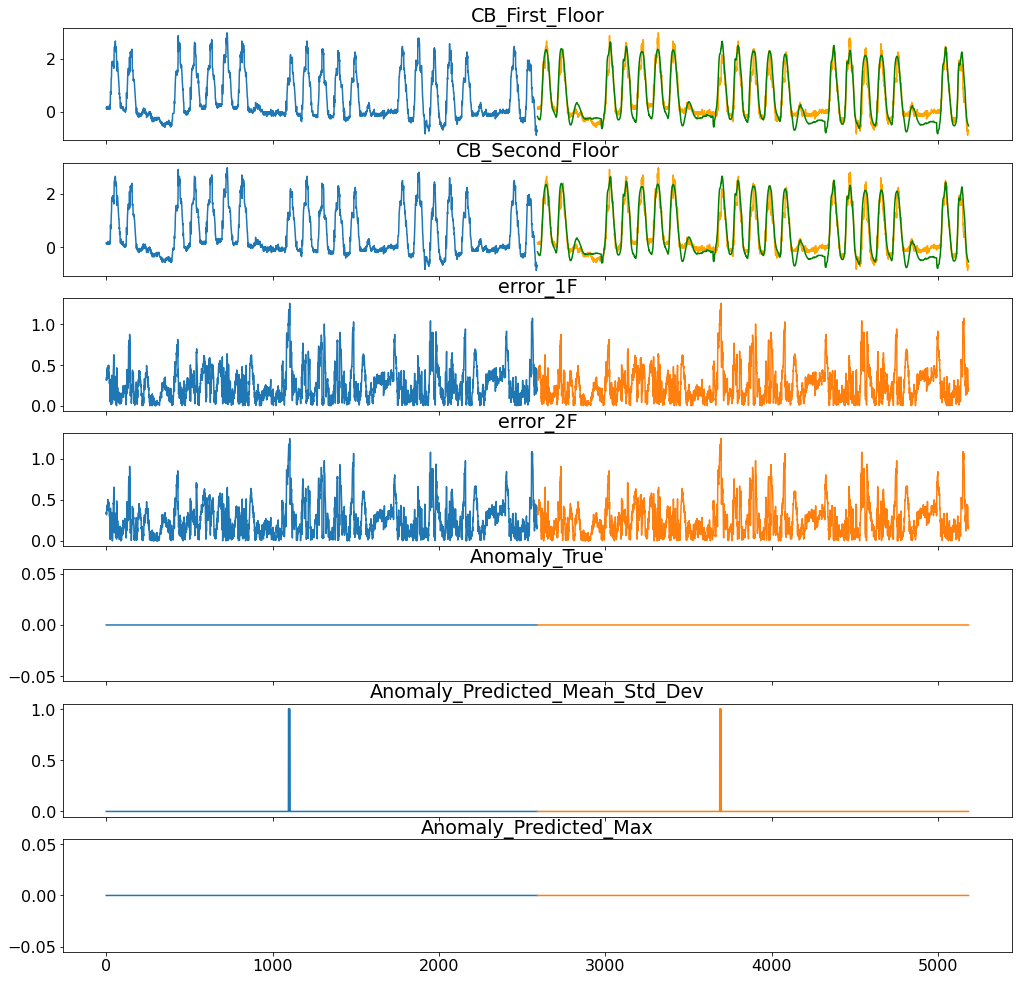

In [63]:
# Plotting reconstructions for a check
import datetime as dt

i=109 # da 89 in poi
j=i+5

X = np.array(X_test_raw.loc[i*672:j*672][['CB_First_Floor', 'CB_Second_Floor']])
predictions = np.array(X_test_raw.loc[i*672:j*672][['Reconstr_1_Floor', 'Reconstr_2_Floor']])
anomaly_true = X_test_raw.loc[i*672:j*672]['Anomaly_Label_GT']
anomaly_prediction_mean_std_dev = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Mean_Std']
anomaly_prediction_max = X_test_raw.loc[i*672:j*672]['Anomaly_Predicted_Max']
error_1F = X_test_raw.loc[i*672:j*672]['Error_1_Floor']
error_2F = X_test_raw.loc[i*672:j*672]['Error_2_Floor']

# Plotting predictions
inspect_multivariate_prediction(X, X, anomaly_true, anomaly_prediction_mean_std_dev, anomaly_prediction_max, predictions, target_labels, error_1F, error_2F) # X = ABB_print

Accuracy: 0.9796
Precision: 0.7077
Recall: 0.6777
F1: 0.6924


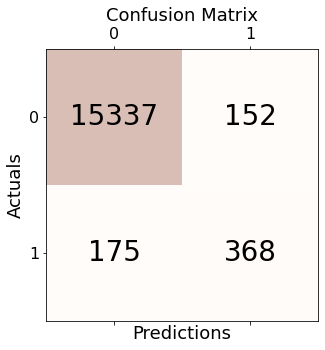

In [54]:
anomaly_predicted = anomaly_predicted_mean_std

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Accuracy: 0.9746
Precision: 0.9857
Recall: 0.2541
F1: 0.4041


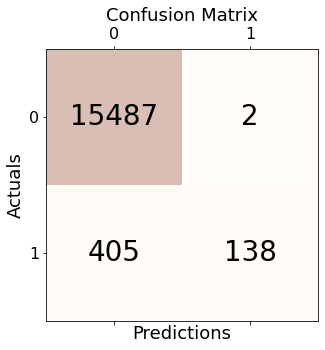

In [55]:
anomaly_predicted = anomaly_predicted_max

# Compute the confusion matrix
cm = confusion_matrix(y_true=Anomaly_Test, y_pred=anomaly_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
precision = precision_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
recall = recall_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
f1 = f1_score(y_true=Anomaly_Test, y_pred=anomaly_predicted)
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(cm, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
        
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()